# Contents
 1. [Load Packages](#1.-Load-Packages)
 2. [Check Dataset](#2.-Check-Datasets)
 3. [Hyperparameter](#3.-Hyperparameter)
 4. [Data Preprocessing](#4.-Data-Preprocessing)
 5. [Model](#5.-Model)
 6. [Train](#6.-Train)
 7. [Evaluate](#7.-Evaluate)
 8. [Save Submission](#8.-Save-Submission)
 ---

# 1. Load Packages

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2, os, glob

np.set_printoptions(threshold=np.inf)
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [1]:
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-07 00:52:27.232984: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 00:52:27.327997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 00:52:29.043751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


---
# 2. Check Datasets

> ---
> ## 2-1. Dataset unzip

In [ ]:
!unzip ../input/aerial-cactus-identification/train.zip
!unzip ../input/aerial-cactus-identification/test.zip

> ---
> ## 2-2. train dataframe merge

classes :  {'1', '0'}
total train images :  17500
                                                  id has_cactus
0  aci/train/train/8f8353e7ece063172c1e94155fc133...          1
1  aci/train/train/f97bf7bce88f066395837e8ebe75a1...          1
2  aci/train/train/d1334d3388af30b815d54cc3659d60...          1
3  aci/train/train/0eef13f167d6626f92fb805926da4e...          1
4  aci/train/train/80d78e3885b23abe02202c7fcf12f8...          1
(32, 32, 3)


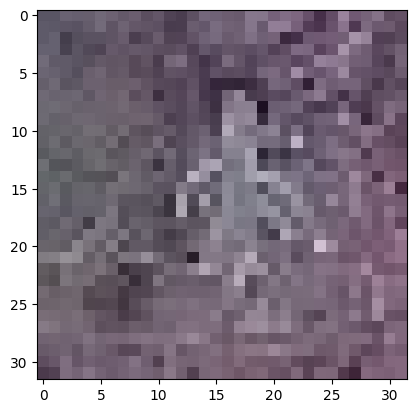

In [23]:
# [ train data ]

# train image paths
file_path = 'aci'
train_dir = 'aci/train/train/'
train_fnames = os.listdir(train_dir)
train_fpaths = [os.path.join(train_dir,fname) for fname in train_fnames]

# train labels
csv_path ='aci/train.csv'
df = pd.read_csv(csv_path)
df.head()

# merge train image paths with labels
train_df = pd.DataFrame(data={'id':train_fpaths,'has_cactus':df['has_cactus']})
train_df = train_df.astype(str) # must replace label dtype to strings

print('classes : ',set(train_df['has_cactus']))
print('total train images : ',len(train_df))
print(train_df.head())

# sample image
sample = train_df['id'][0]
img_sample = Image.open(sample)
image = np.array(img_sample)

print(image.shape)
plt.imshow(image)


In [24]:
print(len(train_fpaths))
print(len(df['has_cactus']))


17500
17500


> ---
> ## 2-3. check sample submission

In [25]:
sub_sample = 'aci/sample_submission.csv'
sample_df = pd.read_csv(sub_sample)
print('submission sample 수 : ',len(sample_df))

test_dir = 'aci/test/test'
test_names = os.listdir(test_dir)
test_paths = [os.path.join(test_dir,fname) for fname in test_names]
print('테스트셋 수 : ',len(test_paths))
sample_df.head()

submission sample 수 :  4000
테스트셋 수 :  4000


,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


> ---
> ## 2-4. train test split

In [26]:
test_df = train_df[-500:]
train_df = train_df[:-500]

---
# 3. Hyperparameter

In [27]:
input_shape = (32,32,3)
batch_size = 32
num_classes =2
num_epochs = 5
learning_rate = 0.01

---
# 4. Data Preprocessing

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                  width_shift_range=0.3,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [29]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                   x_col='id',
                                                   y_col='has_cactus',
                                                   target_size=input_shape[:2],
                                                   batch_size=batch_size,
                                                   class_mode='sparse')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                 x_col='id',
                                                 y_col='has_cactus',
                                                 target_size=input_shape[:2],
                                                 batch_size=batch_size,
                                                 class_mode='sparse')

Found 17000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


---
# 5. Model

In [30]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121

In [31]:
learning_rate = 0.001
num_epochs = 10
model_dir = './model_cactus'

In [32]:
models = {
    'VGG16': tf.keras.applications.VGG16,
    'VGG19': tf.keras.applications.VGG19,
    'ResNet50': tf.keras.applications.ResNet50,
    'MobileNet': tf.keras.applications.MobileNet,
    'DenseNet121': tf.keras.applications.DenseNet121
}

In [13]:
# model = tf.keras.applications.ResNet101(
#     include_top=True, weights='imagenet', input_tensor=None,
#     input_shape=None, pooling=None, classes=1000
# )

# model = tf.keras.applications.VGG16(
#     include_top=True, weights='imagenet', input_tensor=None,
#     input_shape=None, pooling=None, classes=1000,
#     classifier_activation='softmax'
# )

inputs = layers.Input(input_shape)
net = layers.Conv2D(64, (3, 3), padding='same')(inputs)
net = layers.Conv2D(64, (3, 3), padding='same')(net)
net = layers.Conv2D(64, (3, 3), padding='same')(net)
net = layers.BatchNormalization()(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)

net = layers.Conv2D(128, (3, 3), padding='same')(net)
net = layers.Conv2D(128, (3, 3), padding='same')(net)
net = layers.Conv2D(128, (3, 3), padding='same')(net)
net = layers.BatchNormalization()(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Conv2D(256, (3, 3), padding='same')(net)
net = layers.Conv2D(256, (3, 3), padding='same')(net)
net = layers.Conv2D(256, (3, 3), padding='same')(net)
net = layers.BatchNormalization()(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Conv2D(512, (3, 3), padding='same')(net)
net = layers.Conv2D(512, (3, 3), padding='same')(net)
net = layers.Conv2D(512, (3, 3), padding='same')(net)
net = layers.BatchNormalization()(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Conv2D(512, (3, 3), padding='same')(net)
net = layers.Conv2D(512, (3, 3), padding='same')(net)
net = layers.Conv2D(512, (3, 3), padding='same')(net)
net = layers.BatchNormalization()(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net)

model.summary()

2024-06-07 00:42:19.828670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0
2024-06-07 00:42:19.831602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2024-06-07 00:42:19.834346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0
2024-06-07 00:42:19.837085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bu

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                             

---
# 6. Train

In [33]:
for model_name, model_func in models.items():
    # Load the pre-trained model
    model = model_func(weights=None, input_shape=(32, 32, 3), classes=2)
    
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    # Fit the model
    model.fit_generator(train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=num_epochs,
                        validation_data=test_generator,
                        validation_steps=len(test_generator))

    # Save the model
    model_path = f'{model_dir}/{model_name}.h5'
    model.save(model_path)

    # Load the model back
    loaded_model = tf.keras.models.load_model(model_path)

/tmp/ipykernel_1852169/3966629594.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 1/10


2024-06-07 00:59:27.734163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-07 00:59:27.888703: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-07 00:59:28.457439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-07 00:59:28.514980: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8450340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-07 00:59:28.515060: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-06-07 00:59:28.523781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-07 00:59:28.675540: I te

532/532 [==============================] - 44s 57ms/step - loss: 0.6281 - accuracy: 0.7503 - val_loss: 0.5496 - val_accuracy: 0.7620
Epoch 2/10
532/532 [==============================] - 30s 57ms/step - loss: 0.5633 - accuracy: 0.7503 - val_loss: 0.5488 - val_accuracy: 0.7620
Epoch 3/10
532/532 [==============================] - 29s 55ms/step - loss: 0.5627 - accuracy: 0.7503 - val_loss: 0.5494 - val_accuracy: 0.7620
Epoch 4/10
532/532 [==============================] - 30s 57ms/step - loss: 0.5626 - accuracy: 0.7503 - val_loss: 0.5488 - val_accuracy: 0.7620
Epoch 5/10
532/532 [==============================] - 30s 57ms/step - loss: 0.5629 - accuracy: 0.7503 - val_loss: 0.5490 - val_accuracy: 0.7620
Epoch 6/10
532/532 [==============================] - 30s 55ms/step - loss: 0.5626 - accuracy: 0.7503 - val_loss: 0.5488 - val_accuracy: 0.7620
Epoch 7/10
532/532 [==============================] - 29s 54ms/step - loss: 0.5627 - accuracy: 0.7503 - val_loss: 0.5492 - val_accuracy: 0.7620
Epo

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
532/532 [==============================] - 41s 55ms/step - loss: 0.6340 - accuracy: 0.7489 - val_loss: 0.5535 - val_accuracy: 0.7620
Epoch 2/10
532/532 [==============================] - 30s 56ms/step - loss: 0.5633 - accuracy: 0.7503 - val_loss: 0.5488 - val_accuracy: 0.7620
Epoch 3/10
532/532 [==============================] - 29s 55ms/step - loss: 0.5629 - accuracy: 0.7503 - val_loss: 0.5488 - val_accuracy: 0.7620
Epoch 4/10
532/532 [==============================] - 30s 57ms/step - loss: 0.5627 - accuracy: 0.7503 - val_loss: 0.5502 - val_accuracy: 0.7620
Epoch 5/10
532/532 [==============================] - 31s 58ms/step - loss: 0.5629 - accuracy: 0.7503 - val_loss: 0.5508 - val_accuracy: 0.7620
Epoch 6/10
532/532 [==============================] - 30s 56ms/step - loss: 0.5634 - accuracy: 0.7503 - val_loss: 0.5489 - val_accuracy: 0.7620
Epoch 7/10
532/532 [==============================] - 30s 57ms/step - loss: 0.5626 - accuracy: 0.7503 - val_loss: 0.5514 - val_accuracy:

2024-06-07 01:17:02.037692: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmobilenet_1.00_32/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


532/532 [==============================] - 59s 58ms/step - loss: 0.6161 - accuracy: 0.7358 - val_loss: 0.5512 - val_accuracy: 0.7620
Epoch 2/10
532/532 [==============================] - 30s 56ms/step - loss: 0.5822 - accuracy: 0.7455 - val_loss: 0.5846 - val_accuracy: 0.7060
Epoch 3/10
532/532 [==============================] - 29s 55ms/step - loss: 0.5810 - accuracy: 0.7460 - val_loss: 0.5713 - val_accuracy: 0.7620
Epoch 4/10
532/532 [==============================] - 29s 55ms/step - loss: 0.5814 - accuracy: 0.7451 - val_loss: 0.5680 - val_accuracy: 0.7620
Epoch 5/10
532/532 [==============================] - 31s 59ms/step - loss: 0.5947 - accuracy: 0.7460 - val_loss: 0.5533 - val_accuracy: 0.7620
Epoch 6/10
532/532 [==============================] - 30s 56ms/step - loss: 0.5772 - accuracy: 0.7456 - val_loss: 0.5817 - val_accuracy: 0.7620
Epoch 7/10
532/532 [==============================] - 30s 57ms/step - loss: 0.5768 - accuracy: 0.7464 - val_loss: 0.5527 - val_accuracy: 0.7620
Epo

---
# 7. Evaluate

In [34]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tqdm.notebook import tqdm


In [43]:
test_dir = 'aci/test/test'
test_names = os.listdir(test_dir)
test_paths = [os.path.join(test_dir, fname) for fname in test_names]
model_dir = ''

In [44]:
def preprocess_image(image_path):
    img_pil = Image.open(image_path)
    img_array = np.array(img_pil)
    return img_array

In [45]:
def predict_with_model(model, test_paths):
    preds = []
    for test_path in tqdm(test_paths, desc=model.name):
        image = preprocess_image(test_path)
        pred = model.predict(image[np.newaxis, ...])
        pred = np.argmax(pred)
        preds.append(pred)
    return preds


In [50]:
import os

model_dir = os.path.join(os.getcwd(), '')

print("현재 작업 디렉토리:", current_directory)


현재 작업 디렉토리: /home/a202192010/2024/Project_Lecture/ML_kaggle/cactus


In [51]:
for model_name, model_func in models.items():
    # Load the model
    model = tf.keras.models.load_model(f'{model_dir}/{model_name}.h5')
    
    # Make predictions using the model
    preds = predict_with_model(model, test_paths)
    
    # Create a DataFrame for submission
    submission_df = pd.DataFrame(data={'id': test_names, 'has_cactus': preds})
    
    # Save the submission file
    submission_df.to_csv(f'submission_{model_name}.csv', index=False)

vgg16:   0%|          | 0/4000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 47ms/step


vgg19:   0%|          | 0/4000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 50ms/step


resnet50:   0%|          | 0/4000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 58ms/step


mobilenet_1.00_32:   0%|          | 0/4000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 49ms/step


densenet121:   0%|          | 0/4000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 68ms/step
